In [1]:
# Imports

import pandas as pd
from edbo.utils import Data
import numpy as np

# Load DFT descriptor CSV files computed with auto-qchem using pandas
# Instantiate a Data object

# cfr_data = Data(pd.read_csv('descriptors/cfr_data.csv'))

In [2]:
# cfr_data.data

In [2]:
temperature_array = np.linspace(30,140,110,dtype=int)
time_array = np.linspace(10,45,35,dtype=int)
stoichiometry_array = np.linspace(33,66,33, dtype=int)
print(temperature_array)
print(time_array)
print(stoichiometry_array)
temperature_list = temperature_array.tolist()
time_list = time_array.tolist()
stoichiometry_list = stoichiometry_array.tolist()
print(temperature_list)
print(time_list)
print(stoichiometry_list)

[ 30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 140]
[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 45]
[33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56
 57 58 59 60 61 62 63 64 66]
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 1

In [3]:
#parameters in reaction space

components = { 'temperature': temperature_list,        # discrete grid of temperatures
                'time': time_list,              # discrete grid of time
                'stoichiometry': stoichiometry_list          # discrete grid of stoichiometry
                }

encoding = {'temperature':'numeric',                    #numerical encoding
            'time':'numeric',                           #numerical encoding
            'stoichiometry':'numeric'}                  #numerical encoding

# should we add DFT as another input??
#temperature 1 degree 30-140
#time 1-5 minute 1-45min
#stoichiometry |mol fraction | x/(x+y) =0.5  = 1/1+1 0.33-0.66 (write into script)

In [4]:
from edbo.bro import BO_express

# BO object

bo = BO_express(components,                                 # Reaction parameters
                encoding=encoding,                          # Encoding specification
                acquisition_function='EI',                  # Use expectation value of improvement
                init_method='rand',                         # Use random initialization
                batch_size=3,                               # 3 experiments per round
                target='response')                          # Optimize response

# BO_express actually automatically chooses priors
# We can reset them manually to make sure they match the ones from our paper

from gpytorch.priors import GammaPrior

bo.lengthscale_prior = [GammaPrior(2.0, 0.2), 5.0]
bo.outputscale_prior = [GammaPrior(5.0, 0.5), 8.0]
bo.noise_prior = [GammaPrior(1.5, 0.5), 1.0]

In [5]:
bo.obj.domain

,temperature,time,stoichiometry
0,0.0,0.0,0.000000
1,0.0,0.0,0.030303
2,0.0,0.0,0.060606
3,0.0,0.0,0.090909
4,0.0,0.0,0.121212
...,...,...,...
127045,1.0,1.0,0.848485
127046,1.0,1.0,0.878788
127047,1.0,1.0,0.909091
127048,1.0,1.0,0.939394


In [6]:
bo.reaction.get_experiments([0,1,2,3,4])

,temperature_index,time_index,stoichiometry_index
0,30,10,33
1,30,10,34
2,30,10,35
3,30,10,36
4,30,10,37


In [7]:
bo.init_sample(seed=1)                 # Initialize
bo.export_proposed('cfr_init.csv')     # Export design to a CSV file
bo.get_experiments()                   # Print selected experiments

,temperature_index,time_index,stoichiometry_index
58945,81,11,40
63703,85,15,46
61230,83,10,48


In [16]:
bo.save()

In [17]:
from edbo.bro import BO_express

bo = BO_express()
bo.load()

In [8]:
bo.add_results('results/cfr_init.csv')

In [9]:
bo.run()

,temperature,time,stoichiometry
127049,1.0,1.0,1.0
1154,0.0,1.0,1.0
127017,1.0,1.0,0.0


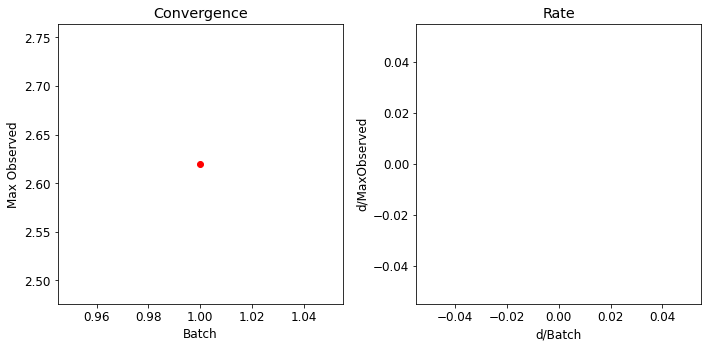

In [10]:
bo.plot_convergence()

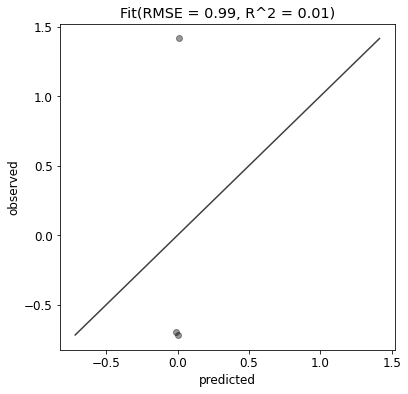

In [11]:
bo.model.regression()

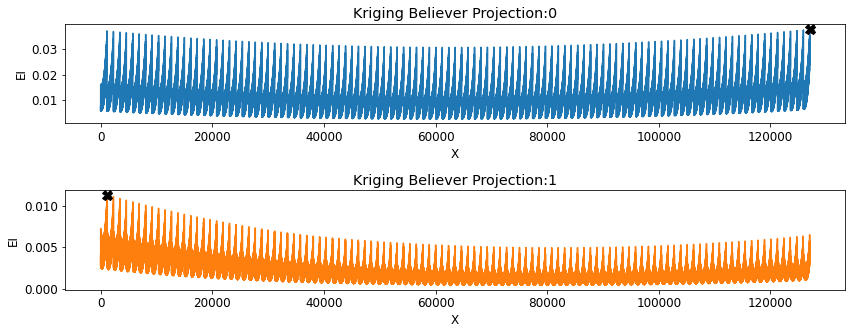

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_kb_projections(n=2):
    """
    Plot 1D projection of Kriging believer parallel batch selection algorithm.
    """

    fig, ax = plt.subplots(len(bo.acq.function.projections[:n]),1, figsize=(12, n * 12 / 5))
    for i, p in enumerate(bo.acq.function.projections[:n]):
        ax[i].plot(range(len(p)), p, color='C' + str(i))
        ax[i].plot([np.argmax(p)], p[np.argmax(p)], 'X', markersize=10, color='black')
        ax[i].set_xlabel('X')
        ax[i].set_ylabel('EI')
        ax[i].set_title('Kriging Believer Projection:' + str(i))
    
    plt.tight_layout()
    plt.show()
    
plot_kb_projections()

In [13]:
bo.export_proposed('round1.csv')

In [14]:
def workflow(export_path):
    """
    Function for our BO pipeline.
    """
    
    bo.run()
    bo.plot_convergence()
    bo.model.regression()
    plot_kb_projections()
    bo.export_proposed(export_path)

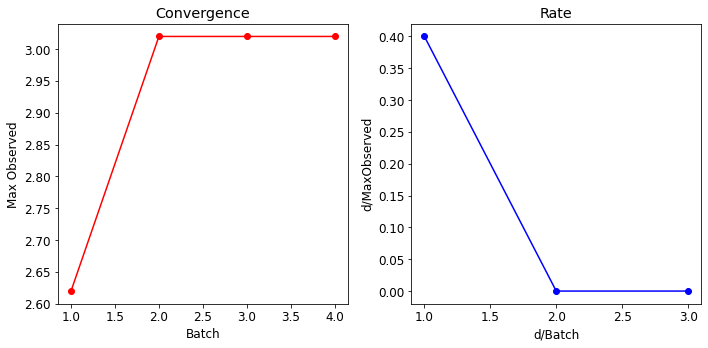

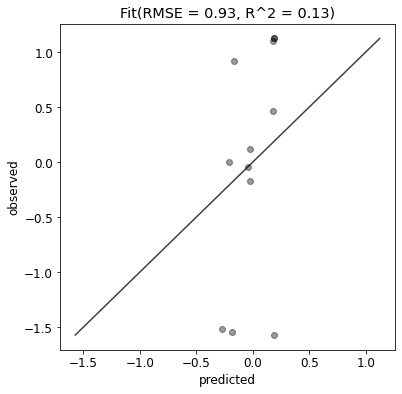

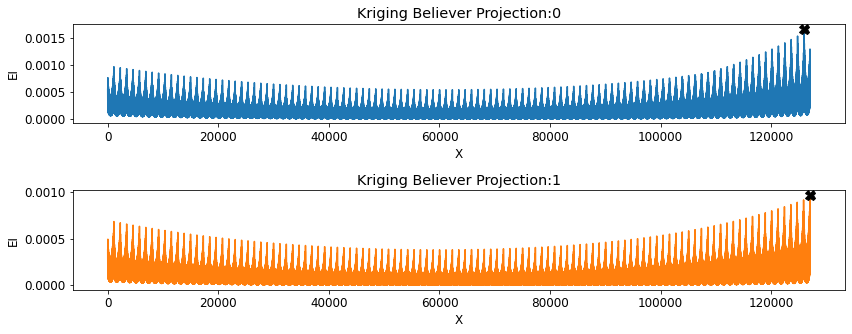

In [17]:
bo.add_results('results/round3.csv')       # Load real results from our experiments
workflow('round4.csv')                     # Run the workflow and export the next experiments to 'round1.csv'

In [18]:
bo.run('round0.csv')

,temperature,time,stoichiometry
14,0.333333,0.000000,1.0
5,0.000000,0.333333,1.0
11,0.000000,1.000000,1.0
